In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [2]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
def function_1(x):
  return (np.sin(5 * (np.pi) * x)) / (5 * np.pi * x)

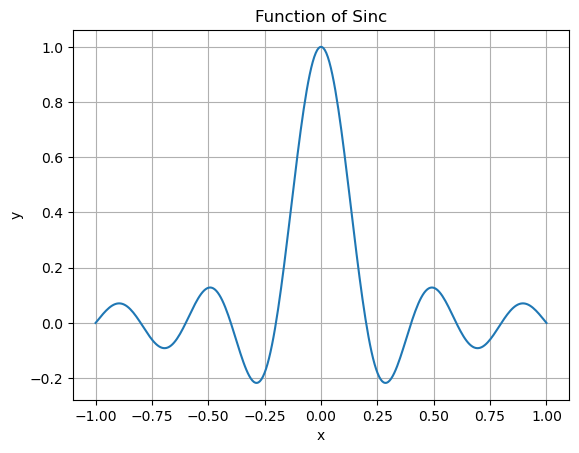

In [4]:
x = np.linspace(-1, 1, 300).reshape(-1, 1)
y = function_1(x)
func1_x, func1_y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
plt.plot(func1_x, func1_y)
plt.title(r'Function of Sinc')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [5]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(1, 5)
        self.linear2 = nn.Linear(5, 10)
        self.linear3 = nn.Linear(10, 10)
        self.linear4 = nn.Linear(10, 10)
        self.linear5 = nn.Linear(10, 10)
        self.linear6 = nn.Linear(10, 10)
        self.linear7 = nn.Linear(10, 10)
        self.linear8 = nn.Linear(10, 10)
        self.linear9 = nn.Linear(10, 5)
        self.predict = nn.Linear(5, 1)
    
    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear1(x))
        x = nn.functional.leaky_relu(self.linear2(x))
        x = nn.functional.leaky_relu(self.linear3(x))
        x = nn.functional.leaky_relu(self.linear4(x))
        x = nn.functional.leaky_relu(self.linear5(x))
        x = nn.functional.leaky_relu(self.linear6(x))
        x = nn.functional.leaky_relu(self.linear7(x))
        x = nn.functional.leaky_relu(self.linear8(x))
        x = nn.functional.leaky_relu(self.linear9(x))

        x = self.predict(x)
        return x

In [6]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

791


In [7]:
def train_model(model, inputs, outputs):
    criterion = nn.MSELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
    max_epochs = 5000 
    losses = []  
    grad_data = []  

    for epoch in range(max_epochs):
        model.train()

        predictions = model(inputs)
        loss = criterion(predictions, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        grad_total = 0.0
        for param in model.parameters():
            if param.grad is not None:
                grad_total += (param.grad.cpu().data.numpy() ** 2).sum()
        grad_norm = grad_total ** 0.5
        grad_data.append(grad_norm)

        if grad_norm < 0.001 or epoch == max_epochs - 1:
            print('Gradient norm reached minimum value or max epochs reached.')

            minimal_ratio, final_loss = calculate_hessian(model, inputs, outputs)
            print(f"Epoch {epoch}, Minimal Ratio: {minimal_ratio}, Loss: {final_loss}")
            break

    return minimal_ratio, final_loss


def calculate_hessian(model, inputs, targets):
    criterion = nn.MSELoss()
    total_params = sum(p.numel() for p in model.parameters())

    predictions = model(inputs)
    loss = criterion(predictions, targets)

    gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    flattened_jacobian = torch.cat([grad.flatten() for grad in gradients])

    hessian_matrix = torch.zeros((total_params, total_params))

    for i in range(total_params):
        second_order_grads = torch.autograd.grad(flattened_jacobian[i], model.parameters(), retain_graph=True)
        hessian_matrix[i] = torch.cat([grad.flatten() for grad in second_order_grads])

    hessian_eigenvalues = torch.linalg.eigvals(hessian_matrix).real

    positive_eigenvalues_count = (hessian_eigenvalues > 0).sum().item()
    minimal_ratio = positive_eigenvalues_count / total_params

    return minimal_ratio, loss.item()


In [8]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index)
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    min_ratio, loss_value = train_model(model, func1_x, func1_x)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

Training model  0
Gradient norm reached minimum value or max epochs reached.
Epoch 2991, Minimal Ratio: 0.5259165613147914, Loss: 1.7545973605592735e-05
Training model  1
Gradient norm reached minimum value or max epochs reached.
Epoch 3753, Minimal Ratio: 0.5195954487989887, Loss: 7.7333468652796e-05
Training model  2
Gradient norm reached minimum value or max epochs reached.
Epoch 3103, Minimal Ratio: 0.5082174462705437, Loss: 1.9146420527249575e-05
Training model  3
Gradient norm reached minimum value or max epochs reached.
Epoch 3674, Minimal Ratio: 0.5195954487989887, Loss: 1.2269214494153857e-05
Training model  4
Gradient norm reached minimum value or max epochs reached.
Epoch 3850, Minimal Ratio: 0.5284450063211125, Loss: 3.480696977931075e-05
Training model  5
Gradient norm reached minimum value or max epochs reached.
Epoch 3347, Minimal Ratio: 0.5132743362831859, Loss: 2.713435242185369e-05
Training model  6
Gradient norm reached minimum value or max epochs reached.
Epoch 3094

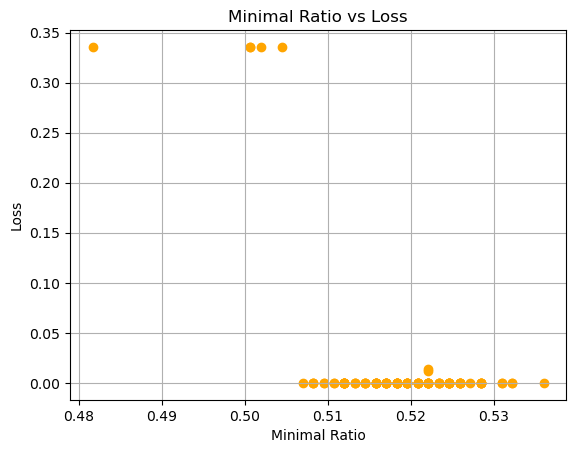

In [9]:
plt.scatter(min_ratio_arr, loss_arr, color="orange")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.title("Minimal Ratio vs Loss")
plt.grid(True)
plt.show()